In [3]:
from collections import Counter
from collections import defaultdict

import json
import pickle

import matplotlib.pyplot as plt

import sys
import glob
import re

from datetime import datetime as dt

import torch
from torch.utils.data import Dataset
#import torch.utils.data

In [1]:
my_path = 'data/wiki/'
#my_path = 'data/guten/'

# Helpers

## functions

In [3]:
def clean_line(line):
    line = line.lower()
    replace = [('\\', ' / '), ('[', ' ( '), ('{', ' ( '), (']', ' ) '), ('}', ' ) ')] # , ('/', ' / ')
    for rep in replace:
        if rep[0] in line:
            line = line.replace(rep[0], rep[1])
    line = re.sub('[^!-@_a-z ]', '', line)
    line = re.findall(r"[\w']+|[^\w\s]", line, re.UNICODE)
    return line

def update_pairs(pairs, pair, frequency, index = set(), remove = False):
    pair_info = pairs.get(pair, [set(), 0])
    if remove:
        frequency = -frequency
        pair_info[0].difference_update(index)
    else:
        pair_info[0] |= index
    pair_info[1] = pair_info[1] + frequency
    return pair_info

def update_tokens(tokens, token, frequency = None, indices = set()):
    if frequency is not None:
        freq = tokens.get(token, 0)
        result = freq + frequency
    else:
        inds = tokens.get(token, set())
        result = indices.union(inds)
    return result

In [4]:
chars_ignore = [',', '.', '-', '(', ')', '"', ':', '=', '&', ';', '!', '/', '$', '+', '%', '<', '>'
                '_', '#', '?', '*', '@', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

# Tokenize

In [5]:
texts = glob.glob(my_path + 'parts/*.txt')

In [8]:
flag_load = True

In [9]:
if flag_load:
    with open(my_path + 'word_freq.json', 'r') as f:
        word_freq = json.load(f)
    with open(my_path + 'char_freq.json', 'r') as f:
        char_freq = json.load(f)
else:
    word_freq = Counter()
    char_freq = Counter()
    for i, file_name in enumerate(texts):
        new_text = []
        with open(file_name, 'r') as f:
            for line in f:
                words = clean_line(line)
                word_freq.update(words)
                new_text.extend(words)
                for word in words:
                    if word in chars_ignore:
                        chars = list(word)
                    else:
                        chars = list(word) + ['^']
                    char_freq.update(chars)
        fn = str(i) + '.txt'
        with open(my_path + 'clean_parts/part_' + fn, 'w') as f:
            for word in new_text:
                f.write('%s\n' % word)
    with open(my_path + 'word_freq.json', 'w') as f:
        json.dump(word_freq, f)
    with open(my_path + 'char_freq.json', 'w') as f:
        json.dump(char_freq, f)

In [10]:
created_tokens = {}
with open(my_path + 'char_freq.json', 'r') as f:
    token_freq = json.load(f)

In [11]:
flag_load = True

In [12]:
if flag_load:
    with open(my_path + 'words_to_index.json', 'r') as f:
        words_to_index = json.load(f)
    with open(my_path + 'index_to_words.json', 'r') as f:
        index_to_words = json.load(f)
    with open(my_path + 'words_tokenized.json', 'r') as f:
        words_tokenized = json.load(f)
else:
    words_to_index = {}
    index_to_words = []
    words_tokenized = []
    for i, word in enumerate(word_freq):
        words_to_index[word] = i
        index_to_words.append(word)
        if word in chars_ignore:
            token_word = list(word)
        else:
            token_word = list(word) + ['^']
        words_tokenized.append(token_word)
    with open(my_path + 'words_to_index.json', 'w') as f:
        json.dump(words_to_index, f)
    with open(my_path + 'index_to_words.json', 'w') as f:
        json.dump(index_to_words, f)
    with open(my_path + 'words_tokenized.json', 'w') as f:
        json.dump(words_tokenized, f)

In [13]:
flag_reset = False

In [14]:
if flag_reset:
    created_tokens = {}
    with open(my_path + 'char_freq.json', 'r') as f:
        token_freq = json.load(f)
    with open(my_path + 'words_tokenized.json', 'r') as f:
        words_tokenized = json.load(f)

In [15]:
flag_load = True

In [16]:
if flag_load:
    with open(my_path + 'pairs.pkl', 'rb') as f:
        pairs = pickle.load(f)
else:
    pairs = {}
    for index, tokens in enumerate(words_tokenized):
        tokens_end = len(tokens) - 1
        frequency = word_freq[index_to_words[index]]
        counter = 0
        for i in range(tokens_end):
            first = tokens[i]
            if first in chars_ignore:
                counter = 0
                continue
            second = tokens[i + 1]
            if second in chars_ignore:
                counter = 0
                continue
            if first == second:
                counter += 1
            else:
                counter = 0
            if counter > 1:
                counter = 0
                continue
            pair = first, second
            pairs[pair] = update_pairs(pairs, pair, frequency, {index})

    with open(my_path + 'pairs.pkl', 'wb') as f:
        pickle.dump(pairs, f)

In [17]:
print(len(word_freq)) # dict word : amount used
print(len(char_freq)) # dict char : amount used (initial)
print(len(token_freq)) # dict char : amount used
print(len(words_to_index)) # dict word : index of the word
print(len(index_to_words)) # list of words
print(len(words_tokenized)) # list of tokenized words
print(len(pairs)) # dict (tuple of pair of tokens) : ({indices of words contained this pair}, amount used)

1395454
43
43
1395454
1395454
1395454
757


In [35]:
words_total = 0
for v in word_freq.values():
    words_total += v
print('amount of words', words_total)

amount of words 295402752


In [18]:
flag_continue = False

In [19]:
if flag_continue:
    with open(my_path + 'token_freq_1.json', 'r') as f:
        token_freq = json.load(f)
    with open(my_path + 'created_tokens_1.pkl', 'rb') as f:
        created_tokens = pickle.load(f)
    with open(my_path + 'words_tokenized_1.json', 'r') as f:
        words_tokenized = json.load(f)
    with open(my_path + 'pairs_1.pkl', 'rb') as f:
        pairs = pickle.load(f)

In [20]:
len(pairs)

757

In [21]:
pairs_plot = []
for val in pairs.values():
    pairs_plot.append(val[1])
pairs_plot.sort()

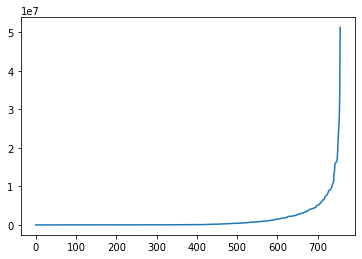

In [28]:
plt.plot(pairs_plot[:])
plt.show()

In [29]:
vocab_full = total_epochs = 0

In [30]:
voc_save_ep = []

In [31]:
pair_min_amount = 2 ** 20 # based on pair frequency
print(pair_min_amount)
abs_pair_min = 2 ** 10
print(abs_pair_min)
vocab_size = 2 ** 15
print(vocab_size)

1048576
1024
32768


In [32]:
epochs = 2 ** 13
print(epochs)

8192


In [36]:
start_time = dt.now()
for ep in range(1, epochs + 1):
    # find frequent pair
    flag_break = False
    flag_seek = True
    max_value = -1
    while flag_seek:
        for pair, value in pairs.items():
            if value[1] > pair_min_amount:
                cur_value = value[1] / (token_freq[pair[0]] * token_freq[pair[1]])
                if cur_value > max_value:
                    max_pair = pair
                    max_value = cur_value
                    flag_seek = False

        if flag_seek:
            pair_min_amount = pair_min_amount // 2
            if pair_min_amount < abs_pair_min:
                print('\nno_more_frequent_pairs')
                flag_break = True
                flag_seek = False
    if flag_break:
        break
            
    total_epochs += 1

    max_pair_indices = pairs[max_pair][0].copy()
    max_pair_count = pairs[max_pair][1]

    #print(max_pair, max_pair_count)

    new_token = ''.join(max_pair)
    token_freq[new_token] = update_tokens(token_freq, new_token, frequency = max_pair_count)  # UPDATING
    created_tokens[new_token] = update_tokens(created_tokens, new_token, indices = max_pair_indices)  # creating
    for tok in max_pair:
        token_freq[tok] -= max_pair_count   # UPDATING token frequency

    # remove all pairs from words with max pair
    for index in max_pair_indices:
        tokens = words_tokenized[index]
        tokens_end = len(tokens) - 1
        frequency = word_freq[index_to_words[index]]
        locations = []
        counter = 0
        for i in range(tokens_end):
            first = tokens[i]
            if first in chars_ignore:
                counter = 0
                continue
            second = tokens[i + 1]
            if second in chars_ignore:
                counter = 0
                continue
            if first == second:
                counter += 1
            else:
                counter = 0
            if counter > 1:
                counter = 0
                continue
            pair = first, second
            pairs[pair] = update_pairs(pairs, pair, frequency, {index}, remove = True) # Updating pairs
            if pairs[pair][1] < 1:
                del pairs[pair]        # Updating pairs
            if pair == max_pair:
                locations.append(i)

        # update tokenized word with new created token
        new_tokens = []
        point = 0
        for i in locations:
            new_tokens = new_tokens + tokens[point : i]
            point = i + 2
            new_tokens.append(new_token)
        new_tokens = new_tokens + tokens[point:]
        words_tokenized[index] = new_tokens      # Updating tokenized words

        tokens_end = len(new_tokens) - 1
        counter = 0
        for i in range(tokens_end):
            first = new_tokens[i]
            if first in chars_ignore:
                counter = 0
                continue
            second = new_tokens[i + 1]
            if second in chars_ignore:
                counter = 0
                continue
            if first == second:
                counter += 1
            else:
                counter = 0
            if counter > 1:
                counter = 0
                continue
            pair = first, second
            pairs[pair] = update_pairs(pairs, pair, frequency, {index})      # Updating pairs

    # remove tokens with low frequency
    for tok in max_pair:
        if tok in created_tokens and token_freq[tok] <= pair_min_amount:
            indices = created_tokens[tok].copy()
            del created_tokens[tok]    # deleting created token from created tokens
            del token_freq[tok]        # deleting token from tokens
            for index in indices:
                tokens = words_tokenized[index]
                tokens_end = len(tokens) - 1
                frequency = word_freq[index_to_words[index]]

                counter = 0
                for i in range(tokens_end):
                    first = tokens[i]
                    if first in chars_ignore:
                        counter = 0
                        continue
                    second = tokens[i + 1]
                    if second in chars_ignore:
                        counter = 0
                        continue
                    if first == second:
                        counter += 1
                    else:
                        counter = 0
                    if counter > 1:
                        counter = 0
                        continue
                    pair = first, second
                    pairs[pair] = update_pairs(pairs, pair, frequency, {index}, remove = True) # Updating pairs
                    if pairs[pair][1] < 1:
                        del pairs[pair]        # Updating pairs

                locations = []
                for l, t in enumerate(tokens):
                    if t == tok:
                        locations.append(l)

                tok_amount = len(locations)
                original_chars = list(tok)
                for char in original_chars:
                    token_freq[char] += frequency * tok_amount # UPDATING

                new_tokens = []
                point = 0
                for i in locations:
                    new_tokens = new_tokens + tokens[point : i] + original_chars
                    point = i + 1
                new_tokens = new_tokens + tokens[point:]
                words_tokenized[index] = new_tokens      # Updating tokenized words

                tokens_end = len(new_tokens) - 1
                counter = 0
                for i in range(tokens_end):
                    first = new_tokens[i]
                    if first in chars_ignore:
                        counter = 0
                        continue
                    second = new_tokens[i + 1]
                    if second in chars_ignore:
                        counter = 0
                        continue
                    if first == second:
                        counter += 1
                    else:
                        counter = 0
                    if counter > 1:
                        counter = 0
                        continue
                    pair = first, second
                    pairs[pair] = update_pairs(pairs, pair, frequency, {index})      # Updating pairs


    if len(token_freq) == vocab_size - 1:
        voc_save_ep.append(total_epochs)
        vocab_full = total_epochs
        #print('vocab is full')
        with open(my_path + 'token_freq_0.json', 'w') as f:
            json.dump(token_freq, f)
        with open(my_path + 'created_tokens_0.pkl', 'wb') as f:
            pickle.dump(created_tokens, f)
        with open(my_path + 'words_tokenized_0.json', 'w') as f:
            json.dump(words_tokenized, f)
        with open(my_path + 'pairs_0.pkl', 'wb') as f:
            pickle.dump(pairs, f)
        #break

    if total_epochs % 100 == 0:
        with open(my_path + 'token_freq_1.json', 'w') as f:
            json.dump(token_freq, f)
        with open(my_path + 'created_tokens_1.pkl', 'wb') as f:
            pickle.dump(created_tokens, f)
        with open(my_path + 'words_tokenized_1.json', 'w') as f:
            json.dump(words_tokenized, f)
        with open(my_path + 'pairs_1.pkl', 'wb') as f:
            pickle.dump(pairs, f)
    if ep % 10 == 0:
        elapsed = dt.now() - start_time
        secs = elapsed.seconds
        ratio = ep / epochs
        printout = '\r[%-25s] %d%%, ep: %d , %02d:%02d:%02d:%02d, tokens: %d, min_freq: %d, voc_f/tot_ep: %d/%d'
        sys.stdout.write(printout % ('='*round(25 * ratio), round(100 * ratio), ep, elapsed.days, secs // 3600, 
                            secs // 60 % 60, secs %60, len(token_freq), pair_min_amount, vocab_full, total_epochs))
        sys.stdout.flush()
sys.stdout.write('\n')
print('done')

[========                 ] 32%, ep: 2640 , 00:00:16:21, tokens: 14617, min_freq: 1024, voc_f/tot_ep: 0/19024
no_more_frequent_pairs

done


In [55]:
voc_save_ep

[]

In [37]:
flag_save = True

In [38]:
if flag_save:
    with open(my_path + 'token_freq_0.json', 'w') as f:
        json.dump(token_freq, f)
    with open(my_path + 'created_tokens_0.pkl', 'wb') as f:
        pickle.dump(created_tokens, f)
    with open(my_path + 'words_tokenized_0.json', 'w') as f:
        json.dump(words_tokenized, f)
    with open(my_path + 'pairs_0.pkl', 'wb') as f:
        pickle.dump(pairs, f)

# Train tokenizer to tokenize

In [4]:
class My_dataset(Dataset):
    def __init__(self, pairs_encoded):
        self.pairs = pairs_encoded
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
        return question, reply

    def __len__(self):
        return self.dataset_size

In [5]:
def train(model, train_loader, criterion, model_optimizer, train_hp, save = False):
    epochs, batch_size, my_path, model_name = train_hp
    loss_train = []
    start_time = dt.now()
    model.train()
    
    for ep in range(1, epochs + 1):
        model.epochs += 1
        loss_tempo = []
        j = 0
        ep_length = len(train_loader)
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            y_input = y[..., :-1]
            y_target = y[..., 1:]
            
            q_mask, r_mask, rt_mask = create_masks(x, y_input, y_target)
            
            out = model(x, q_mask, y_input, r_mask)
            loss = criterion(out, y_target, rt_mask)
            
            model_optimizer.optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            loss_t = loss.item()
            loss_tempo.append(loss_t)
            j += 1
            if j % 100 == 0:
                elapsed = dt.now() - start_time
                secs = elapsed.seconds
                ratio = (j + 1) / ep_length
                printout = '\r[%-16s] %d%%, batch: %d, %02d:%02d:%02d:%02d, epoch: %d/%d, total: %d, loss: %f'
                sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), j, elapsed.days, 
                                        secs // 3600, secs // 60 % 60, secs % 60, ep, epochs, model.epochs, loss_t))
                sys.stdout.flush()
            
        ep_loss = np.mean(np.asarray(loss_tempo), axis=0)
        loss_train.extend(loss_tempo)
        model.losses.append(ep_loss)
        
        if save:
            state = {'model': model, 'model_optimizer': model_optimizer, 'criterion': criterion, 
                     'model_hp' : model_hp}
            torch.save(state, my_path + model_name)
    
    sys.stdout.write('\n')
    return loss_train

In [6]:
def plot_loss(loss):
    plt.plot(loss)
    #plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.show()

In [7]:
def tokenize_word(model, question, word_length, token_map, rev_token_map, parallel):
    """
    Performs Greedy Decoding with a batch size of 1
    """    
    
    question = list(question) + ['^'] 
    question = [token_map[t] for t in question]
    question = torch.LongTensor(question).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    start_token = token_map['^']
    reply = [[start_token]]
    reply = torch.LongTensor(reply).to(device)
    model.eval()
    with torch.no_grad():
        for step in range(word_length - 1):
            dims = reply.size(-1)
            reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
            reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
            if parallel:
                decoded = model.encode_decode(question, question_mask, reply, reply_mask)
            else:
                encoded = model.encode(question, question_mask)
                decoded = model.decode(encoded, question_mask, reply, reply_mask)
            predictions = model.out(decoded[:, -1])
            next_word = torch.argmax(predictions, dim = 1)
            next_word = next_word.item()
            reply = torch.cat([reply, torch.LongTensor([[next_word]]).to(device)], dim = 1)
            if rev_token_map[next_word][-1] == '^':
                break

        # Construct Sentence
        if reply.dim() == 2:
            reply = reply.squeeze(0)
            reply = reply.tolist()

        word = [rev_token_map[k] for k in reply[1:]]
    
    return word

# prepare the data

In [8]:
print(my_path)

data/wiki/


In [9]:
flag_load = False

In [10]:
if flag_load:
    with open(my_path + 'token_map.json', 'r') as f:
        token_map = json.load(f)
else:
    with open(my_path + 'token_freq_0.json', 'r') as f:
        token_freq = json.load(f)
    token_map = {k : v + 1 for v, k in enumerate(token_freq)}
    #token_map['<unk>'] = len(token_map) + 1
    #token_map['<start>'] = len(token_map) + 1
    token_map['<pad>'] = 0
    
with open(my_path + 'words_to_index.json', 'r') as f:
    words_to_index = json.load(f)
with open(my_path + 'words_tokenized_0.json', 'r') as f:
    words_tokenized = json.load(f)
    
with open(my_path + 'char_freq.json', 'r') as f:
    char_freq = json.load(f)
char_map = {k : v + 1 for v, k in enumerate(char_freq)}
#token_map['<unk>'] = len(token_map) + 1
#token_map['<start>'] = len(token_map) + 1
char_map['<pad>'] = 0
    
rev_token_map = {v: k for k, v in token_map.items()}

In [11]:
flag_save = True

In [12]:
if flag_save:
    with open(my_path + 'token_map.json', 'w') as f:
        json.dump(token_map, f)

In [13]:
vocab_size_in = len(char_map)
print(vocab_size_in)

59


In [14]:
vocab_size_out = len(token_map)
print(vocab_size_out)

23756


In [15]:
word_length = 32

## create data_loader

In [16]:
word_tokens_pairs = []
for w, i in words_to_index.items():
    if len(w) < word_length:
        pads = [char_map['<pad>']] * (word_length - len(w) - 1)
        word = list(w) + ['^'] 
        word = [char_map[t] for t in word] + pads
        toks = words_tokenized[i]
        pads = [token_map['<pad>']] * (word_length - len(toks))
        word_toked = [token_map['^']] + [token_map[t] for t in toks] + pads
        word_tokens_pairs.append((word, word_toked))

In [17]:
batch_size = 64

In [18]:
train_loader = torch.utils.data.DataLoader(My_dataset(word_tokens_pairs),
                                           batch_size = batch_size, 
                                           shuffle=True, 
                                           pin_memory=True)

# Model

In [19]:
%run Transformer_class.ipynb

In [20]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
def create_order(d_emb, repeat, deep):
    order = []
    hidden = [d_emb * 2, d_emb, d_emb, d_emb // 2]
    for dh in hidden:
        h = dh // 16
        for _ in range(deep):
            for _ in range(repeat):
                order.append((dh, h))
            h = max(1, h // 2)
    return order

In [23]:
d_emb = 128
hidden_mult = 4
#order = create_order(d_emb, 1, 4)
# order = [(256, 16), (256, 16), (256, 8), (256, 8), 
#          (128, 8), (128, 8), (128, 4), (128, 4), 
#          (128, 4), (128, 4), (128, 2), (128, 2), 
#          (64, 2), (64, 2), (64, 1), (64, 1)]
order = [(256, 16),   
         (128, 8),   
         (128, 4),   
         (64, 2), (64, 1)]
dropouts = [0, 0, 0]
parallel = True

In [24]:
flag_load = False
model_name = 'tokenizer.pt'

In [25]:
if flag_load:
    state = torch.load(my_path + model_name)
    model_hp = state['model_hp']
    model = state['model']
    model_optimizer = state['model_optimizer']
    criterion = state['criterion']
    vocab_size_in, vocab_size_out, d_emb, hidden_mult,  word_length, order, dropouts, parallels = model_hp
else:
    model_hp = vocab_size_in, vocab_size_out, d_emb, hidden_mult,  word_length, order, dropouts, parallel
    model = Transformer(model_hp).to(device)
    #model = nn.DataParallel(model, device_ids = [0, 1, 2, 3])
    #model.to(f'cuda:{model.device_ids[0]}')
    l2 = 0.0
    learning_rate = 0
    warmup_steps = 4000
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2, amsgrad=False)
    model_optimizer = AdamWarmup(d_emb, warmup_steps, optimizer)
    criterion = LossWithLS(vocab_size_out, 0.1)

In [26]:
print('vocab_size_in', vocab_size_in)
print('vocab_size_out', vocab_size_out)
print('d_emb', d_emb)
print('hidden_mult', hidden_mult)
print('word_length', word_length)
print('order', order)
print('dropouts', dropouts)
print('parallel', parallel)
print('num of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

vocab_size_in 59
vocab_size_out 23756
d_emb 128
hidden_mult 4
word_length 32
order [(256, 16), (128, 8), (128, 4), (64, 2), (64, 1)]
dropouts [0, 0, 0]
parallel True
num of parameters: 11503308


# Running

In [27]:
epochs = 20

In [28]:
train_hp = epochs, batch_size, my_path, model_name

In [ ]:
loss_train = train(model, train_loader, criterion, model_optimizer, train_hp, save = True)

[========        ] 48%, batch: 60900, 03:01:34:39, epoch: 15/20, total: 15, loss: 0.07921162

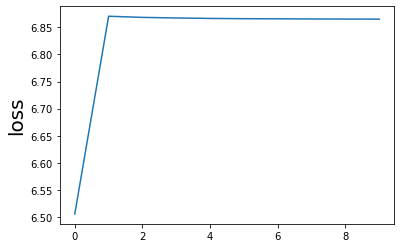

In [65]:
plot_loss(loss_train)
plot_loss(model.losses)

In [75]:
while(1):
    question = input("Question: ") 
    if question == 'quit':
        break
    question = clean_line(question)[0]
    sentence = tokenize_word(model, question, word_length, token_map, rev_token_map, parallel)
    print(sentence)

Question:  question


['question^']


Question:  tokenizer


['to', 'ke', 'ni', 'zer^']


Question:  abracadabra


['a', 'bra', 'ca', 'da', 'bra^']


Question:  quit


In [89]:
flag_save = True

In [90]:
if flag_save:
    state = {'model': model, 'model_optimizer': model_optimizer, 'criterion': criterion, 'model_hp' : model_hp}
    torch.save(state, my_path + model_name)

# Works

In [161]:
i = 0
for tok in token_freq:
    i += 1
    if i > 100:
        print(tok)
    if i > 110:
        break

explo
express
juli
jun
jud
ver
ave
have
hou
house
doubt


In [34]:
for toks in words_tokenized[:10]:
    print(toks)

['the^']
['big^']
['pine^']
['band^']
['of^']
['ow', 'ens^']
['valley^']
['pa', 'i', 'ute^']
['indians^']
['have^']
